In [1]:
import numpy as np
import matplotlib.pyplot as plt

/home/pdcg/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def IMF(m, mtrunc):
    if type(m) == np.ndarray:
        imf = np.exp(-m/mtrunc)/m**2
        mask = m < 1e3
        imf[mask] = np.exp(-1e3/mtrunc)/1e3**2
        return imf
    else:
        if m < 1e3:
            return np.exp(-1e3/mtrunc)/1e3**2
        else:
            return np.exp(-m/mtrunc)/m**2

def mIMF(m, mtrunc):
    if type(m) == np.ndarray:
        imf = np.exp(-m/mtrunc)/m
        mask = m < 1e3
        imf[mask] = np.exp(-1e3/mtrunc)/1e3
        return imf
    else:
        if m < 1e3:
            return np.exp(-1e3/mtrunc)/1e3
        else:
            return np.exp(-m/mtrunc)/m

def envelope(m):
    return m**(-2)

def inverse_CDF_envelope(u, norm, min):
    return 1/(1/min - u/norm)

def trapz_log(min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(1, n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(current, mtrunc) + IMF(next, mtrunc))
    return integral

In [3]:
def draw_mass(min, max, mtrunc, ax, Nreg, norm, env_norm):
    u = np.random.uniform()
    # env_norm = 1/(1/min - 1/max)
    guess1 = inverse_CDF_envelope(u, env_norm, min)

    guess2 = np.random.uniform()
    if (norm*IMF(1e3, mtrunc) > env_norm*envelope(1e3)):
        scale_factor = (norm * IMF(1e3, mtrunc))/(env_norm * envelope(1e3))
    else:
        scale_factor = 1.

    criterion = norm*IMF(guess1, mtrunc)/(scale_factor * env_norm*envelope(guess1))

    if (guess2<criterion):
        ax.plot(guess1, scale_factor * env_norm * guess2 * envelope(guess1), 'xg')
        return guess1, Nreg
    else:
        Nreg += 1
        ax.plot(guess1, scale_factor * env_norm * guess2 * envelope(guess1), '.r')
        return draw_mass(min, max, mtrunc, ax, Nreg, norm, env_norm)

In [4]:
# Msun = 1.989e33
low = 1e2 #*Msun
high = 1e8 #*Msun
mtrunc = 1e6 #*Msun

marray = np.logspace(np.log10(low), np.log10(high), 10000)
IMFarray = IMF(marray, mtrunc)

norm = 1/trapz_log(low, high, mtrunc, IMF, 10000)
mean_mass = norm*trapz_log(low, high, mtrunc, mIMF, 10000)
print("mean cluster mass: {:.3e}".format(mean_mass))

Envarray = envelope(marray)
env_norm = 1/(1/low - 1/high)

mean cluster mass: 3.822e+03


In [5]:
if (norm*IMF(1e3, mtrunc) > env_norm*envelope(1e3)):
    scale_factor = (norm * IMF(1e3, mtrunc))/(env_norm * envelope(1e3))
else:
    scale_factor = 1.

[Text(0.5, 0, '$M$ [$M_\\odot$]')]

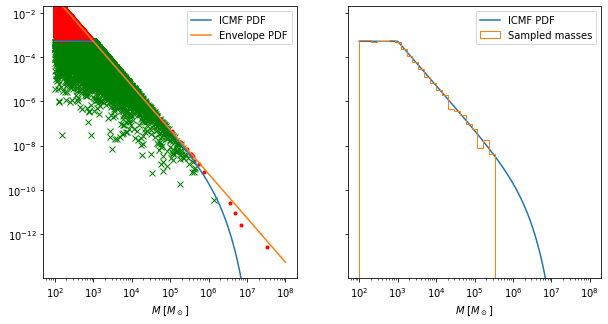

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

Nreg = 0
masses = []
for i in range(10000):
    drawn, Nreg = draw_mass(low, high, mtrunc, ax[0], Nreg, norm, env_norm)
    if(np.random.uniform() > 0.75):
        masses.append(drawn)
masses = np.array(masses)

ax[0].loglog(marray, norm * IMFarray, label='ICMF PDF')
ax[0].loglog(marray, scale_factor * env_norm * Envarray, label='Envelope PDF')
ax[0].set(xscale='log', yscale='log')
ax[0].set(ylim=(env_norm * envelope(high), 2e-2))
ax[0].legend(loc='upper right')
ax[0].set(xlabel=r'$M$ [$M_\odot$]')

bins = np.logspace(np.log10(low), np.log10(high), 40)
ax[1].loglog(marray, norm*IMFarray, label = 'ICMF PDF')
ax[1].hist(masses, bins=bins, histtype='step', density=True, label='Sampled masses')
ax[1].legend(loc='upper right')
ax[1].set(xlabel=r'$M$ [$M_\odot$]')

# plt.savefig("IMF_sampling.pdf")

In [7]:
Nreg

42866

In [8]:
masses.size

2403

# Inverse Sampling trial with known distribution

In [9]:
dist = []
for i in range(10000):
    u = np.random.uniform()
    m = inverse_CDF_envelope(u, env_norm, low)
    dist.append(m)

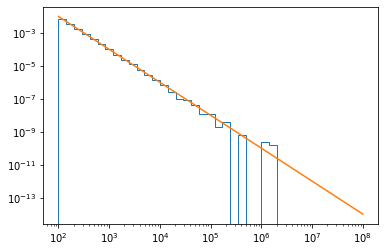

In [10]:
plt.hist(dist, bins=bins, histtype='step', density=True)
plt.loglog(marray, env_norm * Envarray)

# Tview vs CFE

In [63]:
data_cfe = np.loadtxt("../tview_cfe.txt")
data_fbound = np.loadtxt("../tview_fbound.txt")
data_fcce = np.loadtxt("../tview_fcce.txt")

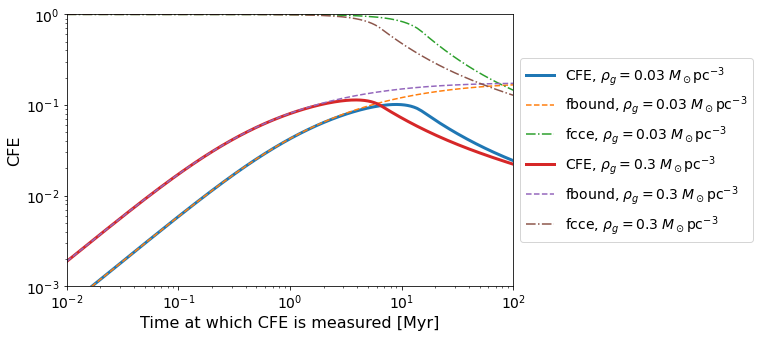

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(data_cfe[:,0]/3.15576e13, data_cfe[:,1], linewidth=3, label=r'CFE, $\rho_g = 0.03 \; M_\odot \rm{pc}^{-3}$')
plt.plot(data_fbound[:,0]/3.15576e13, data_fbound[:,1], '--', label=r'fbound, $\rho_g = 0.03 \; M_\odot \rm{pc}^{-3}$')
plt.plot(data_fcce[:,0]/3.15576e13, data_fcce[:,1], '-.', label=r'fcce, $\rho_g = 0.03 \; M_\odot \rm{pc}^{-3}$')
plt.plot(data_cfe[:,0]/3.15576e13, data_cfe[:,2], linewidth=3, label=r'CFE, $\rho_g = 0.3 \; M_\odot \rm{pc}^{-3}$')
plt.plot(data_fbound[:,0]/3.15576e13, data_fbound[:,2], '--', label=r'fbound, $\rho_g = 0.3 \; M_\odot \rm{pc}^{-3}$')
plt.plot(data_fcce[:,0]/3.15576e13, data_fcce[:,2], '-.', label=r'fcce, $\rho_g = 0.3 \; M_\odot \rm{pc}^{-3}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2, 1e2)
plt.ylim(1e-3, 1e0)
plt.xlabel('Time at which CFE is measured [Myr]', fontsize=16)
plt.ylabel('CFE', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
